import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

Set a random seed to ensure reproducible results

In [2]:
np.random.seed(42)

Load data

Read the medical dataset from a CSV file,
containing features such as age, gender, heart rate, blood pressure, and the outcome label of heart attack.

In [24]:
url = 'https://raw.githubusercontent.com/LAfishableman/project/refs/heads/main/Medicaldataset.csv'
data = pd.read_csv(url)

Data cleaning

Convert the Result column to binary (1 for positive, 0 for negative)

In [4]:
data['Result'] = data['Result'].map({'positive': 1, 'negative': 0})

Check for missing values and print the results to facilitate an understanding of data integrity.

In [35]:
print("missing value：\n", data.isnull().sum())

missing value：
 Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64


Handle outliers.

In [34]:
data = data[data['Heart rate'] < 200]  # Remove heart rate outliers.
data = data[(data['Systolic blood pressure'] < 300) & (data['Diastolic blood pressure'] < 200)]  
# Remove blood pressure outliers.
data = data[data['Blood sugar'] < 500]  # Remove blood glucose outliers.
data = data[data['CK-MB'] < 300]  # Limit CK-MB values within a reasonable range.

Separate features and labels
Divide the dataset into features (X) and target variables (y, Result column)

In [7]:
X = data.drop('Result', axis=1)
y = data['Result']

Feature Standardization

Normalize numerical features using StandardScaler to ensure all features have similar scales, enhancing model training stability

Standardize the features, transforming them into a distribution with a mean of 0 and a standard deviation of 1

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data Splitting

Divide the dataset into a training set (80%) and a test set (20%), using stratified sampling to maintain the proportion of positive and negative labels

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y, test_size=0.2, stratify=y, random_state=42)

Model Training

Initialize the Random Forest Classifier, setting a random seed to ensure reproducibility of results

In [10]:
rf = RandomForestClassifier(random_state=42)

Define the hyperparameter grid for grid search to optimize model performance

In [11]:
param_grid = {
    'n_estimators': [100, 200],  # Number of trees, test 100 and 200 trees
    'max_depth': [10, 20, None],  # Maximum tree depth, None indicates no limit
    'min_samples_split': [2, 5]  # Minimum number of samples required for node splitting
}

Use grid search to optimize the model, aiming to maximize recall

In [12]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall')

Fit the model on the training set to find the best hyperparameters.

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall')

Best Model

In [31]:
best_model = grid_search.best_estimator_
print("Best Parameters：", grid_search.best_params_)

Best Parameters： {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


Model Evaluation

In [26]:
y_pred = best_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.9691119691119691
Precision:  0.9869281045751634
Recall:  0.9617834394904459
F1 Score:  0.9741935483870968
ROC-AUC Score:  0.9710877981765954


Cross-validation

In [27]:
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='recall')
print("Cross-validation Recall: ", cv_scores.mean())

Cross-validation Recall:  0.9834556155768766


Confusion Matrix

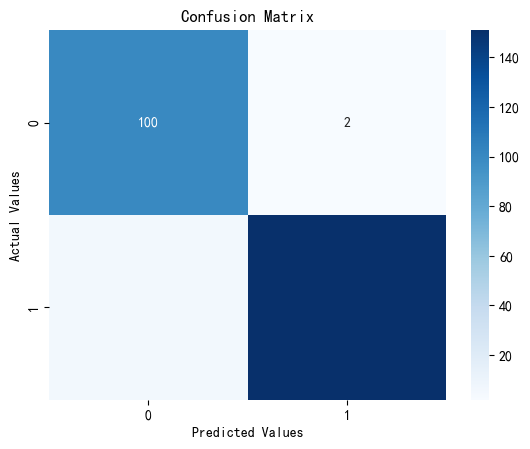

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

feature importance

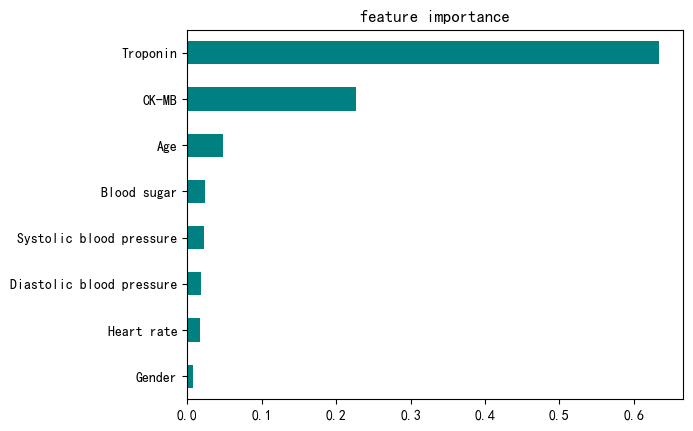

In [29]:
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', color='teal')
plt.title('feature importance')
plt.show()

ROC Curve

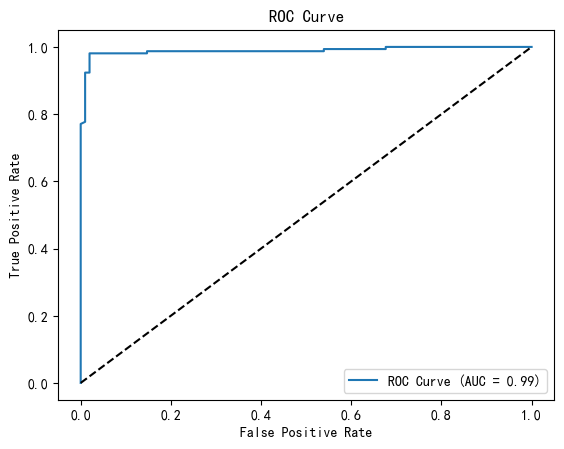

In [30]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()